# Exploring PyTorch and Transformers for Genomic Sequence Classification

## Outline:
1. Objectives
2. What is *deep learning*?
3. Practice
    * Dataset
    * Models
    * Training
    * Evaluation
4. Conclusions

# Objectives

1. Learn the basic theory and practice of deep learning
2. Understand the basic deep learning workflow
3. Deploy a model for genomic sequence classification
    * With helpers
    * Manually

# What is *Deep Learning*?
Deep Learning is a subset of machine learning techniques that uses **artificial neural network**-based models (ANN). What makes it **deep** is the presence of many transformation *layers* within the models. Figure 1 shows a Venn diagram of the organization between artificial intelligence, machine and deep learning. 
Deep learning models are able to learn from raw data. This is one of the main differences against traditional learning pipelines. With these kind of models you can assemble a learning system that tunes itself automatically rather than fixing and updating each individial component one by one. It replaces some of the labor-intensive processes needed for other methods, like field-specific data preprocessing and/or manual feature extraction. Deep learning models can learn and process these features in an automated fashion, generate accurate predictions, and be fine-tuned for specific applications when an available model exist.

One of the most common and persistent disadvantages of applying deep learning methods in your work is the large amount of data needed to train the model. To capture the features and generalize the phenomena in your studies, a substantial amount of data (sometimes labeled) must be available so the model can fit them and produce accurate predictions. However, with the ever-increasing availability of graphical processing units (GPUs), the massive amounts of data generated in clinical and biological scenarios, and the possibility of fine-tuning existing models, implementing a deep learning architecture for your specific applications is becoming increasingly simple.

<fig>
<img    src="images/ENG_IA_ML_DL.png"
        width=600
        height=600>
<figcaption>Fig. 1: Venn diagram displaying the organization between AI, machine, and deep learning.
</figure>

# Deep Learning implementation workflow

In [54]:
# This cell of code is used to import the necessary libraries for the notebook
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchtext.data.utils import get_tokenizer
import torch.optim as optim

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

import gdown

from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from tqdm.auto import tqdm

from genomic_benchmarks.data_check import list_datasets, info, is_downloaded
from genomic_benchmarks.loc2seq import download_dataset
from genomic_benchmarks.dataset_getters.pytorch_datasets import HumanEnhancersCohn

## Dataset

We will be working with the **Genomic Benchmarks** datasets, a set of benchmarks for classification of genomic sequences to test models' capabilities. All the datasets are described in [[2]](https://doi.org/10.1186/s12863-023-01123-8). Grešová and their collaborators created this python module for easy access to well-labeled and balanced datasets as well as to enable reproducibility for genomic-related deep learning models.

In the next code cell we list the available datasets in the **Genomic Benchmarks** module:

In [2]:
list_datasets()

['demo_human_or_worm',
 'human_ocr_ensembl',
 'human_nontata_promoters',
 'human_enhancers_cohn',
 'demo_coding_vs_intergenomic_seqs',
 'drosophila_enhancers_stark',
 'dummy_mouse_enhancers_ensembl',
 'human_enhancers_ensembl',
 'human_ensembl_regulatory']

For illustrative pourpuses you will work on the `human_enhancers_cohn` dataset which contains multiple genomic sequences that **are** or **are not** enhancers. 
In machine learning verbose, you will work on a **binary classification** problem. We can display some information of this dataset as follows:

In [3]:
info("human_enhancers_cohn", version=0)

Dataset `human_enhancers_cohn` has 2 classes: negative, positive.

All lengths of genomic intervals equals 500.

Totally 27791 sequences have been found, 20843 for training and 6948 for testing.


,train,test
negative,10422,3474
positive,10421,3474


### What is an enhancer?

An **enhancer** is a genomic regulatory element that influences gene transcription. It can be located quite far from the gene it regulates, sometimes up to 1 million base pairs away. Although enhancers don't produce any direct products, they play a crucial role in regulating gene expression. This is significant because many diseases are caused or associated with deficiencies in specific genes. 

You may have encountered a similar term, which is **promoter**. The difference between promoters and enhancers is their proximity to the gene they regulate. Promoters are close to the gene they affect. Their functionality are pretty the same, cause the affected gene to over-express and generate more products or proteins than it would normally do.

<fig>
<img    src="images/dna_double_helix.jpg"
        width=600
        height=600>
<figcaption>Fig. 2: AI-generated representation of a DNA double-helix.
</figure>

The `genomic_benchmarks` module offers multiple data handlers and helpers to load, show and give you an idea of how each of its datasets are composed.
In the next code cell we use the `HumanEnhancersCohn` function to download and assign the dataset into two variables, `train_dataset` and `test_dataset`, respectively.

In [4]:
# Load the dataset and split it into training and test sets
train_dataset = HumanEnhancersCohn(split="train", version=0)
test_dataset = HumanEnhancersCohn(split="test", version=0)

Just to make sure we imported the correct dataset we can print the lengths of each set and check if the numbers match the ones shown above.

In [5]:
# Print the lengths of each set check if they match the info we saw previously
print(f"Length of the training dataset: {len(train_dataset)}. Length of the test dataset: {len(test_dataset)}") 

Length of the training dataset: 20843. Length of the test dataset: 6948


But how this data actually look like? You have only downloaded some data from a library for binary classification up to this point. How can you actually see some samples? Turns out to be very easy to do so! Let's see two examples, one for the `positive` and one for the `negative` dianogses, correspondingly.

In [6]:
# Get a sample from train_dataset with a 1 on the second element of the tuple
positive_sample = next(filter(lambda x: x[1] == 1, train_dataset)) # A 1 indicates that the sample is a positive sample
negative_sample = next(filter(lambda x: x[1] == 0, train_dataset)) # A 0 indicates that the sample is a negative sample
print(f"{positive_sample}\n{negative_sample}")

('AGCAGCAGGTCAACATTTTTGCACTCACAAAATAATTTGGAAAAACTATATACCTCTTTCACATTTTTTTTTTTTTGAGATGGAGTCTCACTCTGTCGCCCAGGCTGGAGTGCAGTGGTGCAATCTCGGCTCACTGCAAGCTCTGACTCCTGGATTCATGCCATTCGCCTGCCTCAGCCTCCCGAGTAGCTGGGACTATAGGCGCCCGCCACCATGCCTGGCTAATTTTTTGTATTTTTAGTAGAGACGGGGTTTCCCCGTGTTAGCCAGGACGGTCTCTAGCTCCTGACCTTGCGATCCACCTGCCTCGGCCTCCCAAAGTGCTGGGATTACAGGCATGAGCCACTGCACCAGGCCCTCTTTCACATTTTTAAGTTTTCTGTTATCTATTTCAAAAGGTGTAGTTAACATATTTTAAATATTAACAATTCAAAAATAAAACTATTATAGAATTTTTAAACAGTATCCAGATAAATTTTTATTATTAATTTCATACTCAA', 1)
('CTGATGAAACCCGGCGAGGTGTGGTCTGCCCTGGAGGACAGCAGCCAGTGTGGGGGGCAGTCCCTTCTCTCTGTCCCAAGGGAGGATACAGCTCCACTGTGGTCACTGGCTCTATGTGAGGGGGTGCATGCATCAGAGACAACAGATGAGAGGGCCCTTCAGTTGGCTTTTCTGCCTCCAGTTCTTTCTGTTCATGAGAGGAAAAGCTACTGGTAGACAGAACAATGTTAAATGTAATAAAAATAAGCAAGTTCCCTGGGTTTATGCAGTGCCAAATGTCAAGATGGTTGTATACAGGAGAAGACGTCCAAGACACGTCTTTTCCGAGTGTCCCAGAGCTCAGAACTCTGTGAGCACTTTGAGCTTCCCCAGACCTCTTTCTTCCCTGGGTGTGAGCCCTGCACAGTGCTCCGAAAAGAGCTGGGGTCCGTAAATACGGATGGCAAACAGCTCACCTGGGTTTCTCACATGGATTTGTTTTCTTGGGGGT

Can you tell, without looking at the corresponding labels, which of these sequences is positive for an enhancer and which is not?
Well, you can determine this by some other studies like genome-wide chromatin immunoprecipitation or RNA sequencing. But if you saw these sequences alone, would you be able to tell whether it is an enhacer or not? A deep learning model can do it! At the cost of massive amounts of already-labeled data that were obtained with techniques like the previously mentioned ones (that is, what we just downloaded).

You already have downloaded the dataset, but it isn't ready to be used with a neural network yet. PyTorch neural networks expect their inputs to be arranged in a special data structure known as **tensor**s. If you have experience with Numpy's `ndarray`s getting to know tensors will be pretty easy. These are *n*-dimensional number arrays optimized for gradient calculus and other operations that run in the background when training a neural network. More information about tensors and specifications on [Pytorch's website](https://pytorch.org).

Now, how does a tensor look like? In the following code cells we initialize random tensors and display them just for illustrative purposes.

In [7]:
my_tensor = torch.tensor([1, 2, 3, 4, 5]) # As you can see, it takes a list an input
print(my_tensor)

tensor([1, 2, 3, 4, 5])


Tensor's data type is an important consideration always. Many errors arise when tensor's data types aren't the same bewteen the inputs and the labels. Specifically, this error arises when calculating the **loss**, a value that measures the difference between the model predictions and the ground-truth (your labels).

In [8]:
my_tensor.dtype # Using the dtype attribute, we can see the data type of the tensor

torch.int64

You can manipulate tensors by adding or removing elements, changing their data types, do any mathematical or arithmetical operation with them, etc.

In [9]:
my_tensor = my_tensor.to(torch.float64) # We can change the data type of the tensor using the .float() method
print(my_tensor.dtype)

torch.float64


In [10]:
tensor_mul = my_tensor * my_tensor # We can perform element-wise multiplication on tensors
print(tensor_mul)

tensor([ 1.,  4.,  9., 16., 25.], dtype=torch.float64)


## Tokenizaton
Now that you know you need these sequences in a specific format, the next question is: how do you transform these sequences into representable tensors? The answer lies in the **Natural Language Processing** (NLP) field. NLP is a sub-field in computer science and AI that uses different kinds of algorithms to enable computers to understand human spoken language. Its applications range from text encoding and generation to voice recognition and speaking systems. Some examples in daily life are chatbots and digital assistants (Alexa, Bixby, Siri, Google Assistant).

In this case you are working on sequence classification, this means each of these sequences have an inherent "grammar" or structure that define them as an enhancer or not. As in NLP they analyze sentence grammatics and decompose them by encoding each word, you're going to do the same. The process of encoding words and turning them into meaningful numerical representations is called **tokenization**.

Nowadays it is really easy to implement and use a tokenizer to convert your raw genomic sequences into representable numbers. Thanks to HuggingFace's `transformers` and `tokenizers` libraries, you can download and use pretrained neural networks and their corresponding tokenizers.

In [11]:
# instantiate tokenizer
checkpoint = 'LongSafari/hyenadna-tiny-1k-seqlen-hf' # This is the model's name we are going to use
max_length = 1024 # This variable will represent the maximum length of the input sequences

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True)

Let's apply this tokenizer to the first sequence to look how the data comes out of it.

In [12]:
enconded_sequence = tokenizer(train_dataset[0][0])
print(enconded_sequence)

{'input_ids': [8, 10, 9, 7, 10, 9, 7, 7, 7, 8, 8, 8, 9, 9, 8, 9, 7, 9, 9, 10, 9, 10, 9, 9, 10, 8, 10, 9, 8, 8, 8, 10, 9, 9, 7, 9, 9, 7, 8, 7, 9, 8, 7, 9, 8, 8, 7, 9, 10, 9, 10, 9, 9, 9, 9, 9, 9, 8, 7, 9, 10, 8, 8, 8, 10, 10, 8, 10, 8, 10, 8, 10, 9, 10, 8, 8, 8, 7, 7, 9, 9, 9, 7, 9, 9, 7, 10, 7, 8, 7, 9, 8, 10, 8, 8, 7, 8, 10, 9, 10, 9, 9, 10, 8, 7, 8, 10, 9, 9, 8, 10, 8, 10, 7, 10, 9, 10, 9, 7, 9, 9, 9, 9, 9, 10, 9, 8, 7, 10, 9, 8, 7, 10, 8, 7, 9, 7, 9, 7, 8, 7, 7, 8, 7, 9, 7, 10, 9, 7, 9, 7, 9, 9, 9, 8, 8, 8, 10, 10, 8, 7, 9, 10, 10, 9, 9, 8, 10, 10, 10, 10, 8, 10, 9, 8, 8, 10, 8, 8, 7, 9, 10, 10, 8, 10, 10, 10, 8, 10, 9, 10, 10, 8, 7, 10, 9, 7, 9, 7, 9, 9, 7, 7, 7, 7, 9, 8, 10, 7, 8, 10, 9, 9, 10, 7, 9, 7, 8, 7, 9, 7, 7, 8, 7, 7, 10, 9, 10, 10, 7, 7, 7, 10, 9, 10, 7, 7, 10, 7, 7, 7, 7, 7, 10, 7, 7, 9, 8, 7, 7, 9, 10, 10, 8, 8, 8, 10, 9, 9, 9, 10, 10, 10, 7, 10, 9, 8, 7, 9, 10, 9, 8, 8, 7, 7, 7, 10, 9, 10, 8, 7, 7, 9, 7, 10, 9, 9, 10, 10, 9, 10, 7, 10, 7, 8, 7, 9, 9, 7, 9, 7, 7, 9, 7,

As you can see, now your sequences is represented as a bunch of numbers. Each of them represents each of the nucleotides that conform the sequences we used as input and the tokenizer adds some special tokens to differentiate from sequence to sequence when passed into the training phase. Let's see how the network will read your sequences in meaningful way for you.

In [13]:
decoded = tokenizer.decode(enconded_sequence['input_ids'])
print(decoded)

CTGATGAAACCCGGCGAGGTGTGGTCTGCCCTGGAGGACAGCAGCCAGTGTGGGGGGCAGTCCCTTCTCTCTGTCCCAAGGGAGGATACAGCTCCACTGTGGTCACTGGCTCTATGTGAGGGGGTGCATGCATCAGAGACAACAGATGAGAGGGCCCTTCAGTTGGCTTTTCTGCCTCCAGTTCTTTCTGTTCATGAGAGGAAAAGCTACTGGTAGACAGAACAATGTTAAATGTAATAAAAATAAGCAAGTTCCCTGGGTTTATGCAGTGCCAAATGTCAAGATGGTTGTATACAGGAGAAGACGTCCAAGACACGTCTTTTCCGAGTGTCCCAGAGCTCAGAACTCTGTGAGCACTTTGAGCTTCCCCAGACCTCTTTCTTCCCTGGGTGTGAGCCCTGCACAGTGCTCCGAAAAGAGCTGGGGTCCGTAAATACGGATGGCAAACAGCTCACCTGGGTTTCTCACATGGATTTGTTTTCTTGGGGGTCTCTGTATGG[SEP]


If you want to obtain the PyTorch tensors directly just add the `return_tensors="pt"` parameter.

In [14]:
encoded_tensors = tokenizer(train_dataset[0][0], return_tensors='pt')
print(encoded_tensors)

{'input_ids': tensor([[ 8, 10,  9,  7, 10,  9,  7,  7,  7,  8,  8,  8,  9,  9,  8,  9,  7,  9,
          9, 10,  9, 10,  9,  9, 10,  8, 10,  9,  8,  8,  8, 10,  9,  9,  7,  9,
          9,  7,  8,  7,  9,  8,  7,  9,  8,  8,  7,  9, 10,  9, 10,  9,  9,  9,
          9,  9,  9,  8,  7,  9, 10,  8,  8,  8, 10, 10,  8, 10,  8, 10,  8, 10,
          9, 10,  8,  8,  8,  7,  7,  9,  9,  9,  7,  9,  9,  7, 10,  7,  8,  7,
          9,  8, 10,  8,  8,  7,  8, 10,  9, 10,  9,  9, 10,  8,  7,  8, 10,  9,
          9,  8, 10,  8, 10,  7, 10,  9, 10,  9,  7,  9,  9,  9,  9,  9, 10,  9,
          8,  7, 10,  9,  8,  7, 10,  8,  7,  9,  7,  9,  7,  8,  7,  7,  8,  7,
          9,  7, 10,  9,  7,  9,  7,  9,  9,  9,  8,  8,  8, 10, 10,  8,  7,  9,
         10, 10,  9,  9,  8, 10, 10, 10, 10,  8, 10,  9,  8,  8, 10,  8,  8,  7,
          9, 10, 10,  8, 10, 10, 10,  8, 10,  9, 10, 10,  8,  7, 10,  9,  7,  9,
          7,  9,  9,  7,  7,  7,  7,  9,  8, 10,  7,  8, 10,  9,  9, 10,  7,  9,
          7,  

The output's data structure is a dictionary containing the `input_ids` key which contains the actual tensors you're going to use to train your model.

The `genomic_benchmarks` datasets contain their labels already in a tensor format. If we load these dataset in another pytorch-specific data structure called `DataLoader` we can display mini-batches of samples from the whole dataset. This looks as follows:

In [15]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
for batch, (x, y) in enumerate(train_loader):
    print(f"Batch number: {batch}\nInputs: {x}\nLabels: {y}")
    break

Batch number: 0
Inputs: ('ATAAAGACACAGGATGTCCAGTGACATTTGAATTTCAGAAAACAATAAAGTTTTTTTTAGTATAATTATGTCTCTTGCAATGTATGGTACCTATTTATACCAAAAGTGATTTGTCATTGATCTAAAATTCAAATTTTACCGGATATTCTGTATTTTTCTGGCAACACTACCCTAGGCATGAGAGTATAGGAATGAGGGTGGTTATTGGAACACACAGGGTCGGTGATATTTGGAAGTGAAGGGCGACCTAGTGGGAGTTACAACCTGCCTTACAGGAACAAAGCCAAATGGGACAGGGAATGAGCTGGAGAAATAAGGATTCTGAGCTTGCTCTCCTCTTCCTGTCTTCCAATTGTCTGCTGGTATCTCTGATTATTAGGACAATCCAGAAACTAGAGGCCAGATCAGCCTGTTGACCTGCTCCAATGGTTTCCATGGAGATAGGTCTTCCAGGGCATTGAGGAGGGCATGGAAAAAGGAAGAGCATGGATCTAGAAGGC', 'CATCCAGGTAGAAGAATCAGCAGGCACAAAGATGCGGAGGCCCAGGAGGCATTTGGCTTGAGGCCAGTGCAGTTTGCTTCAGCATGGCTGCTCTGCAGAATCCCAGAGGACCAGTGGTAAAGGAGGAGGTCTTTCCCTGAGACCATTTTCATCAGGCCTGGGCAGGCATGATGCAGGCAGGCCCAGGTCAAGGAGAGCTTTGGTTTCCAGCTGGGGAGCCTTGTGGCTTAGGGATGGGCTTTTAAGCAGTGGCAAGATGTGATTGTCACTGTTCCAGATGGGTGGGTCTCTTCGCTTTCCTCATGCCCCACCGTGCTGTGCTCACATGGTTGCTGTGATGTCCAACCCTCTGGGTAAATTTTACTCATCCCTGAGGCCTAACTCGAGTCTTGCCCCTGGAGTAAAGCCCTTCATGACTACTGTAGCCCACACCTTCCTCCTTTCCTCCAAATGTTTTTATTTTTCCAGTC

Let's apply the transformation we just learned to convert the sequences into meaningful tensors:

In [17]:
for batch, (x, y) in enumerate(train_loader):
    x = tokenizer(x, return_tensors='pt', padding=True, truncation=True, max_length=max_length)["input_ids"]
    print(f"Batch number: {batch}\nInputs: {x}\nLabels: {y}")
    break

Batch number: 0
Inputs: tensor([[ 7,  9,  7,  ...,  8,  8,  1],
        [ 9, 10,  7,  ...,  9,  7,  1],
        [10, 10,  7,  ..., 10, 10,  1],
        ...,
        [ 7,  8,  9,  ...,  9,  7,  1],
        [10, 10,  9,  ...,  7, 10,  1],
        [ 7,  9,  8,  ...,  9,  9,  1]])
Labels: tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 0])


Excellent! Now you can see the relationship between the sequences and labels contained in the dataset. Let's now load the model you're going to train! It's really important to keep in mind that if you're going to use a pretrained model (as you are doing right now), you have to use the same `checkpoint` for both the tokenizer and the model. Doing so you will give the inputs to the model as it expects and avoid lots of error messages.

## Model training

In [18]:
# Load the model using the same checkpoint as the tokenizer
# The num_labels parameter is set to 2 because we have two classes in the dataset (positive and negative)

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, trust_remote_code=True, labels=2)

Some weights of HyenaDNAForSequenceClassification were not initialized from the model checkpoint at LongSafari/hyenadna-tiny-1k-seqlen-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You are almost there to train your model! You're a few parameters and functions away of training the model. Let's finish the set up to start the training process!

To start its training a deep learning model needs:
* a `device`: the piece of hardware where all the math will happen. It's advised to use a GPU for accelerated training
* `loss function`: this tells you how much difference is there between the model's precictions and the ground-truth labels in the dataset
* a number of `epochs`: the amount of times the model will "see" the samples within the dataset
* an `optimizer`: a way of calculating and update the model's parameters to fit better the data after each iteration
* a `training` and `test` loops: to declare how the information will pass through the network and in which moment to update the parameters

Let's declare them in the following code cell:

In [19]:
# Define the optimizer and the loss function
loss_fn = nn.CrossEntropyLoss()

# create optimizer and define its parameters
learning_rate = 1e-5
weight_decay = 0.1
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Define a device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [20]:
# Define the training loop
def train(model, device, train_loader, max_length):
    model.to(device)
    model.train()
    size = len(train_loader.dataset)
    for batch, (x, y) in enumerate(train_loader):
        x = tokenizer(x, return_tensors='pt', padding=True, truncation=True, max_length=max_length)["input_ids"] # Tokenize the input sequences
        x, y = x.to(device), y.to(device) # Move the data to the device
        # Forward pass
        outputs = model(x, labels=y) # Get the outputs of the model
        # Backward pass
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        # Zero the gradients
        optimizer.zero_grad()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [21]:
# Define the test loop
def test(model, device, test_loader, max_length, losses, accuracies):
    model.to(device) # Move the model to the device
    model.eval() # Set the model to evaluation mode
    size = len(test_loader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad(): # Disable gradient calculation
        for x, y in test_loader:
            x = tokenizer(x, return_tensors='pt', padding=True, truncation=True, max_length=max_length)["input_ids"] # Tokenize the input sequences
            x, y = x.to(device), y.to(device) # Move the data to the device
            outputs = model(x, labels=y) # Get the outputs of the model
            test_loss += outputs.loss.item() # Get the loss value
            correct += (outputs.logits.argmax(1) == y).type(torch.float).sum().item() # Get the number of correct predictions
    test_loss /= size
    losses.append(test_loss) # Save the loss value in the current epoch
    correct /= size
    accuracies.append(correct) # Save the accuracy value in the current epoch
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Now you have all the parameters, objects, and functions needed to train a deep learning model! The last thing you have to do is to declare how many **epochs** the training phase will have. This is how many times will the model "see" or process all the samples contained in the training dataset. This is done to try to fit the model as most as possible to the data. That's why your dataset has to include a wide variety of examples, covering the most cases as possible from the phenomenon you're studying.

In [22]:
# Define the number of epochs
epochs = 5

# Define the lists to store the losses and accuracies
losses = []
accuracies = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train(model, device, train_loader, max_length)
    test(model, device, test_loader, max_length, losses, accuracies)

Epoch 1
-------------------------------
loss: 0.703496  [   32/20843]
loss: 0.667997  [ 3232/20843]
loss: 0.635347  [ 6432/20843]
loss: 0.643703  [ 9632/20843]
loss: 0.557363  [12832/20843]
loss: 0.542455  [16032/20843]
loss: 0.639422  [19232/20843]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.018850 

Epoch 2
-------------------------------
loss: 0.619926  [   32/20843]
loss: 0.523954  [ 3232/20843]
loss: 0.572760  [ 6432/20843]
loss: 0.489192  [ 9632/20843]
loss: 0.476640  [12832/20843]
loss: 0.527408  [16032/20843]
loss: 0.643266  [19232/20843]
Test Error: 
 Accuracy: 69.0%, Avg loss: 0.018230 

Epoch 3
-------------------------------
loss: 0.487059  [   32/20843]
loss: 0.507019  [ 3232/20843]
loss: 0.591919  [ 6432/20843]
loss: 0.464435  [ 9632/20843]
loss: 0.477468  [12832/20843]
loss: 0.494074  [16032/20843]
loss: 0.574226  [19232/20843]
Test Error: 
 Accuracy: 70.2%, Avg loss: 0.017901 

Epoch 4
-------------------------------
loss: 0.624282  [   32/20843]
loss: 0.408304  [ 3232/2

## Evaluation

Excellent! You just finished training your model, now what? Is it ready to predict which sequence is an enhancer and which is not? As you may saw during the training process at the end of each epoch the accuracy and average loss values were displayed. These tell us how **reliable** our model is. You can plot these values and watch the model's evolution through the epochs because each time the `test` function was working it saved them.

### Accuracy and Loss

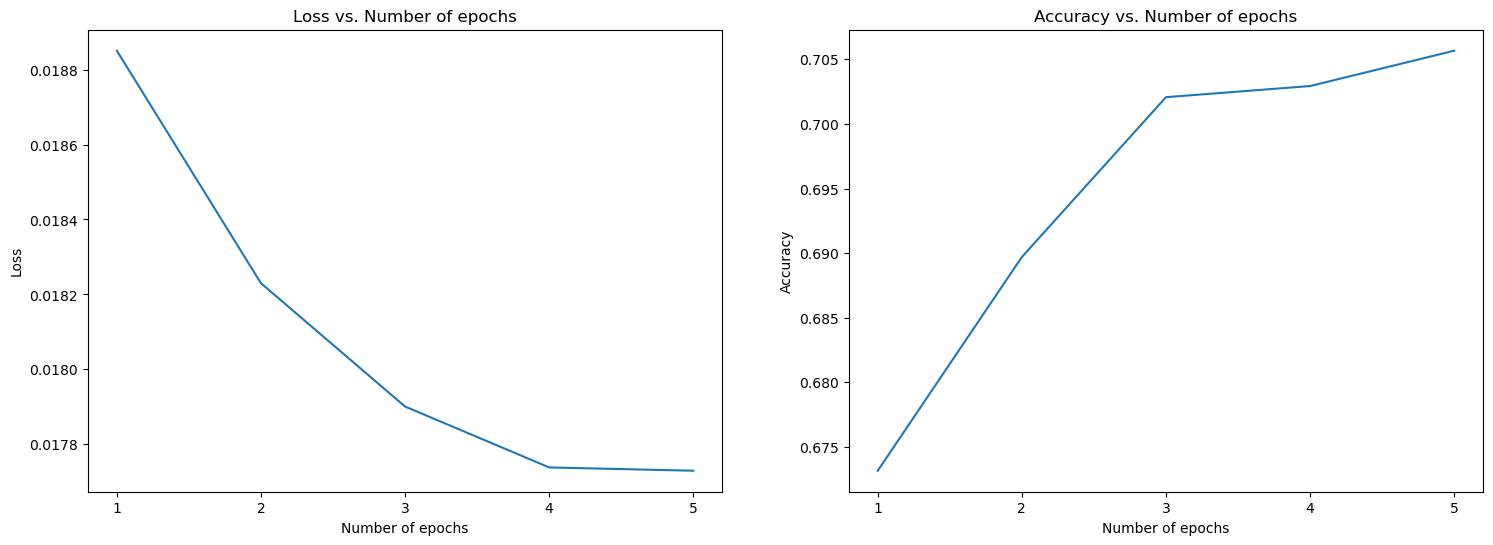

In [23]:
# Plot the loss and accuracy values agianst the number of epochs
n_epochs = np.arange(1, epochs + 1) # Create an array with the number of epochs
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(n_epochs, losses)
plt.xticks(n_epochs)
plt.title("Loss vs. Number of epochs")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(n_epochs, accuracies)
plt.xticks(n_epochs)
plt.title("Accuracy vs. Number of epochs")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.show()

As you may see in the plots, the **loss value** decreases as the number of epochs increases. The loss value is a metric that tells you how far from the actual values the model's predictions are. This value and they way it is calculated are directly related to the **loss function**, in this example you used the *Cross Entropy* loss function. 

On the other hand, the **accuracy** represents the quantity of correct predictions out of the total number of samples (in the test dataset). With this model, in the specific iteration when preparing this workshop, the maxmimum obtained value was 70.6%. This means that if you use this model for any medical or diagnostic application you would detect an enhancer correctly 70% percent of the time. Do you think this accuracy is enough?

### Confusion matrix

Another way of assessing how well your model works is with a **confusion matrix**. This is a metric that quantifies and shows the number of correct predictions against the incorrect ones. It compares the number of predicted values against the true ones, allowing to check how often the model misses to clasify correctly a sample.

To calculate it you just need to generate predictions with your model and compare them against the labels contained in the dataset. In the next code cell it's showed how to do this.

In [24]:
# Do infenrece on the test set
model.to(device) # Move the model to the device
model.eval() # Set the model to evaluation mode
size = len(test_loader.dataset) # Get the size of the test set
test_loss, correct = 0, 0 
y_pred = [] # Create a list to store the predictions
with torch.no_grad(): # Disable gradient calculation
    for x, y in test_loader:
        x = tokenizer(x, return_tensors='pt', padding=True, truncation=True, max_length=max_length)["input_ids"] # Tokenize the input sequences
        x, y = x.to(device), y.to(device) # Move the data to the device
        outputs = model(x, labels=y) # Get the outputs of the model
        test_loss += outputs.loss.item() # Get the loss value
        correct += (outputs.logits.argmax(1) == y).type(torch.float).sum().item() # Get the number of correct predictions
        y_pred.extend(outputs.logits.argmax(1).cpu().numpy()) # Save the predictions in the y_pred list

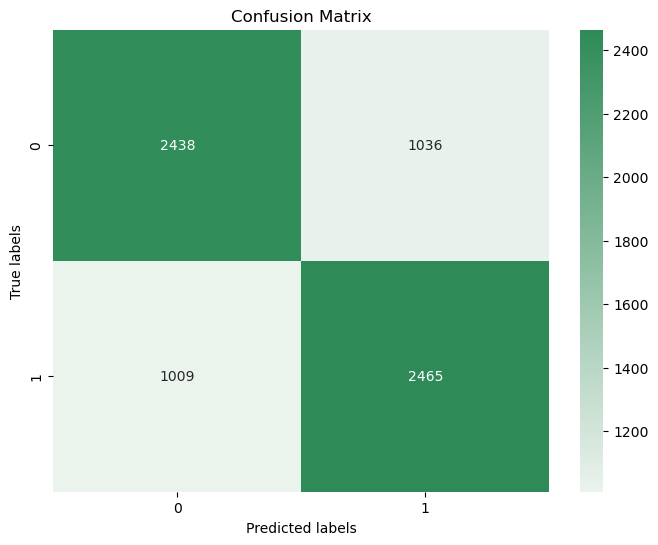

In [46]:
# Calculate confusion matrix 
y_true = test_dataset.all_labels # Get the true labels
confusion_matrix(y_true, y_pred) # Calculate the confusion matrix

# Display the confusion matrix

plt.figure(figsize=(8, 6)) 
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap=sns.light_palette("seagreen", as_cmap=True)) # Create a heatmap of the confusion matrix
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix might initially suggest that the classifier performed well, but this isn’t entirely accurate. Remember that the model’s maximum accuracy was only 70.6%. In a medical setting, this means that out of every 10 patients, 7 would be correctly diagnosed, while 3 would not. As the number of patients increases, the number of incorrect diagnoses will also rise. That's why it is important to use more than one evaluation metric to assess your model's performance!

### Receiver-Operator Characteristic (ROC) curve
The **ROC curve** plots the true positive rate (TPR) against the false positive rate (FPR). While it’s typically used for binary classification tasks, it can also be adapted for multi-class classification with some adjustments. An ideal ROC curve would rise sharply from the origin to the top-left corner and then extend horizontally to the top-right corner. The greater the area under the curve (AUC), the better the classifier’s performance, with a full AUC representing a perfect classifier.

In the next code cell, it is shown how to generate a ROC curve using the same `y_true` and `y_pred` variables as in the confusion matrix.

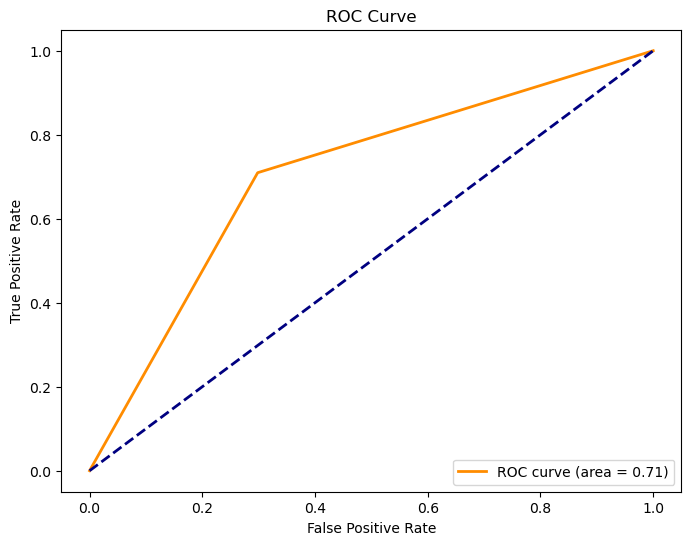

In [48]:
# Plot a ROC curve 
roc_auc = roc_auc_score(y_true, y_pred) # Calculate the ROC AUC score
fpr, tpr, _ = roc_curve(y_true, y_pred) # Calculate the false positive rate and true positive rate
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})') # Plot the ROC curve
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

With the help of the ROC curve it is more clear that the classifier is not ideal for inference in a medical or biological contexts as it would misclassify new and unseen samples.

### Summary on evaluation metrics
* $TP$: True Positives
* $TN$: True Negative
* $FP$: False Positive
* $FN$: False Negative

#### Accuracy
It's the quantity of correct predictions out of the total number of samples within a dataset. Its value is commonly represented from 0% to 100%.

$$Accuracy = \frac{TP + TN}{TP + FN + TN + FP}$$

#### Sensitivity 
It is the true positive rate of the model's test. In other words, means how many of the enhancer sequences were actually categorized as enhancers.
Recall the confusion matrix where 2,465 out of 3,474 sequences were correctly classified (results when preparing the workshop). Its value goes from 0 to 100% as well.

$$Sensitivity = \frac{TP}{TP+FN}$$

#### Specificity
This is the true negative rate when testing a predictive model. In this case it represents the proportion of the sequences that **are not** enhancers are were correctly differentiated from the enhancer sequences. Again, if you see the confusion matrix you can see in the first row that 2,438 sequences out of 3474 were correctly classified as **not enhacers**.

$$Specificity = \frac{TN}{TN+FP}$$

#### Precision
This one represents the truly positive sequences from all the samples that were classified as *positive* by the model. In this case only the second column in the confusion matrix is considered. Its values goes from 0 to 100% too. 

$$Precision = \frac{TP}{TP+FP}$$

#### Confusion matrix

<fig>
<img    src="images/ENG_Confusion_matrix.png"
        width=700
        height=600>
<figcaption>Fig. 3: The confusion matrix explained.
</figure>

# Train a model with your data!

You have successfully trained a deep learning model using a dataset that contains genomic sequences that either are or are not **enhancers**. But what if you have data that are different? Can you still train the same model? How would you pre-process your data to make it compatible with these neural networks?

To finish this workshop, you will download a new dataset in `csv` format containing coding and non-coding sequences (extracted from [7]), transform it into representable tensors, train the model again, and evaluate its performance.

## Prepare the data
The data you're about to download is a `csv` file with genomic sequences representing coding **or** non-coding sequences. This data is located in a drive folder, you can download and give a check to the data with the following code cell.

In [56]:
# Step 1: Get the URL of the CSV file
file_id = "1itLZCkFbeqlscbrrZdhX-9qA5j2Hc_W_"
url = f"https://drive.google.com/uc?id={file_id}"  # Replace with the actual URL of the CSV file

# Step 2: Download the file using gdown
output = 'data.csv'  # The name of the downloaded file
gdown.download(url, output, quiet=False)

# Step 3: Load the CSV file into a DataFrame
df = pd.read_csv(output)

# Display the first few rows of the DataFrame
df.head()

Downloading...
From (original): https://drive.google.com/uc?id=1AzsSCpzxleJ6_FNXIRczgNtQkq51k2ZP
From (redirected): https://drive.google.com/uc?id=1AzsSCpzxleJ6_FNXIRczgNtQkq51k2ZP&confirm=t&uuid=28326c9d-f7d4-4841-8166-4235be37d35c
To: /Users/msr/Documents/workshops/deep_sequence_classification/data.csv
100%|██████████| 477M/477M [02:21<00:00, 3.37MB/s] 


                                           sequences  value
0  GTACTTATTTCAACAGCACATATTTTAAATTGGATCAATACAGAGC...      0
1  ATCACTTCTCGGCCTTTTGGCTAAGATCAACTGTAGTATCTGTTGT...      0
2  GTGCCTGCTTTGGCGGCACATATCCTAAAATTGGAACAATACAGAG...      0
3  ATCACTTCTCGGCCTTTTGGCTAAGATCAACTGTAGTATCTGTTGT...      0
4  ATACTTACCTGGCAGGGCAGATACCATGATCTTAAAGGCAGTTTTC...      0


As you can see you have the raw sequences and their corresponding labels contained in the csv file. To make this data set compatible with PyTorch and HuggingFace models you need to turn it into a `Dataset` object. As you already have many variables containing the information about the model, the tokenizer, the loss function and many others, training again the model will be pretty straightforward.

To create a `Dataset` object run the next code cell:

In [57]:
# Class for ncRNA and cDNA Dataset object
from sklearn.model_selection import train_test_split

class coding_and_noncoding_dataset(Dataset):
    '''
    Class for the coding and noncoding dataset from Ensembl.
    The dataset is a CSV file with two columns: "sequences" and "value". Being 0 for noncoding and 1 for coding.
    You can split the dataset into train and test sets by setting split=True and defining the test_size.
    For reproducibility, you can set the random_seed (defaulted to 42).
    '''
    def __init__(
        self,
        data_path,
        max_length,
        tokenizer = None,
        split='train',
        test_size=0.2,
        random_seed=42,
        use_padding=None,
        add_eos=False,
    ):
        
        self.data = pd.read_csv(data_path)
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.split = split
        self.test_size = test_size
        self.random_seed = random_seed
        self.use_padding = use_padding
        self.add_eos = add_eos

        if self.split == 'train':
            self.seq, _, self.label, _ = train_test_split(self.data['sequences'], self.data['value'],
                                                          test_size=self.test_size, random_state=self.random_seed)
        elif self.split == 'test':
            _, self.seq, _, self.label = train_test_split(self.data['sequences'], self.data['value'],
                                                          test_size=self.test_size, random_state=self.random_seed)

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        x = self.seq.iloc[idx]
        y = self.label.iloc[idx]

        seq = self.tokenizer(x,
            add_special_tokens=False,
            padding="max_length" if self.use_padding else None,
            max_length=self.max_length,
            truncation=True,
        )  # add cls and eos token (+2)
        seq = seq["input_ids"]  # get input_ids

        # need to handle eos here
        if self.add_eos:
            # append list seems to be faster than append tensor
            seq.append(self.tokenizer.sep_token_id)

        # Convert into Long Tensors (y has to be wrapped in a list)
        seq = torch.LongTensor(seq)
        target = torch.LongTensor([y])
        
        return seq, target

Now let's instantiate the train and test sets:

In [80]:
train_set = coding_and_noncoding_dataset(data_path="data.csv",
                                         split='train',
                                         tokenizer=tokenizer,
                                         use_padding=True,
                                         max_length=max_length)

test_set = coding_and_noncoding_dataset(data_path="data.csv",
                                        split='test',
                                        tokenizer=tokenizer,
                                        use_padding=True,
                                        max_length=max_length)

## Train the model
All you have to do is repeat the process you did some minutes ago! As it is already specified in the `coding_and_noncoding_dataset`, the sequences are already tokenized, all you have to do is a little adjustment in the train and test loops and you're good to go!

In [66]:
# Define the training loop
def train(model, device, train_loader, max_length):
    model.to(device)
    model.train()
    size = len(train_loader.dataset)
    for batch, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device) # Move the data to the device
        # Forward pass
        outputs = model(x, labels=y) # Get the outputs of the model
        # Backward pass
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        # Zero the gradients
        optimizer.zero_grad()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


# Define the test loop
def test(model, device, test_loader, max_length, losses, accuracies):
    model.to(device) # Move the model to the device
    model.eval() # Set the model to evaluation mode
    size = len(test_loader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad(): # Disable gradient calculation
        for x, y in test_loader:
            x, y = x.to(device), y.to(device) # Move the data to the device
            outputs = model(x, labels=y) # Get the outputs of the model
            test_loss += outputs.loss.item() # Get the loss value
            correct += (outputs.logits.argmax(1) == y).type(torch.float).sum().item() # Get the number of correct predictions
    test_loss /= size
    losses.append(test_loss) # Save the loss value in the current epoch
    correct /= size
    accuracies.append(correct) # Save the accuracy value in the current epoch
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [81]:
# Redefine the data loaders 
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [82]:
# Define the number of epochs
epochs = 3

# Define the lists to store the losses and accuracies
losses = []
accuracies = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train(model, device, train_loader, max_length)
    test(model, device, test_loader, max_length, losses, accuracies)

Epoch 1
-------------------------------
loss: 0.876782  [   32/24000]
loss: 0.636981  [ 3232/24000]
loss: 0.494365  [ 6432/24000]
loss: 0.684757  [ 9632/24000]
loss: 0.661679  [12832/24000]
loss: 0.524564  [16032/24000]
loss: 0.561022  [19232/24000]
loss: 0.639533  [22432/24000]
Test Error: 
 Accuracy: 1620.4%, Avg loss: 0.017357 

Epoch 2
-------------------------------
loss: 0.417926  [   32/24000]
loss: 0.551330  [ 3232/24000]
loss: 0.631925  [ 6432/24000]
loss: 0.512798  [ 9632/24000]
loss: 0.541104  [12832/24000]
loss: 0.517274  [16032/24000]
loss: 0.583631  [19232/24000]
loss: 0.541040  [22432/24000]
Test Error: 
 Accuracy: 1622.9%, Avg loss: 0.016723 

Epoch 3
-------------------------------
loss: 0.475853  [   32/24000]
loss: 0.537079  [ 3232/24000]
loss: 0.412526  [ 6432/24000]
loss: 0.543385  [ 9632/24000]
loss: 0.545025  [12832/24000]
loss: 0.546756  [16032/24000]
loss: 0.480246  [19232/24000]
loss: 0.359384  [22432/24000]
Test Error: 
 Accuracy: 1620.2%, Avg loss: 0.016138 

To evaluate the performance of the model, you can repeat the steps that were introduced in the *Evaluation* section.

# References

1. Dive into Deep Learning
2. [Genomic Benchmarks paper and repository](https://doi.org/10.1186/s12863-023-01123-8)
3. HuggingFace
4. HyenaDNA
5. [Scikit learn "Multiclass Receiver Operating Characteristic (ROC)"](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py)
6. Erickson, B. J., & Kitamura, F. (2021). Magician’s corner: 9. Performance metrics for machine learning models. Radiology: Artificial Intelligence, 3(3), e200126. https://doi.org/10.1148/ryai.2021200126
7. Harrison, P. W., Amode, M. R., Austine-Orimoloye, O., Azov, A. G., Barba, M., Barnes, I., Becker, A., Bennett, R., Berry, A., Bhai, J., Bhurji, S. K., Boddu, S., Branco Lins, P. R., Brooks, L., Ramaraju, S. B., Campbell, L. I., Martinez, M. C., Charkhchi, M., Chougule, K., … Yates, A. D. (2024). Ensembl 2024. Nucleic Acids Research, 52(D1), D891–D899. https://doi.org/10.1093/nar/gkad1049
